In [1]:
import sys

In [2]:
sys.path.append('/home/bh774267/.local/lib/python3.11/site-packages')

In [3]:
import requests
import pandas as pd
from io import StringIO

In [4]:
import re

In [97]:
!pip install --user fvcore

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61443 sha256=dc17246af34db89b39c7bd9f95191c201849c3417013103260326f22c8140bbb
  Stored in directory: /rwthfs/rz/cluster/home/bh774267/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31570 sha256=719d17ada9a68d16c3d55f6734edf0e1fb94f5f0fa6a5bd12b4714f274cd89e3
  Stored in directory: /rwthfs/rz/cluster/home/bh774267/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [23]:
!pip install --upgrade --user certifi

In [24]:
!pip install --user biopython

  Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (3.2 MB)


In [25]:
!pip install --user biopython-dssp

ERROR: Could not find a version that satisfies the requirement biopython-dssp (from versions: none)
ERROR: No matching distribution found for biopython-dssp


In [26]:
import certifi
print(certifi.where())

/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/lib/python3.11/site-packages/certifi/cacert.pem


In [5]:

# SCOPe release version (e.g., 2.08 or latest)
SCOPE_VERSION = "2.07"

# URLs for SCOPe classification and description files
#base_url = f"https://scop.berkeley.edu/downloads/ver={SCOPE_VERSION}/"
cla_url = f"https://scop.berkeley.edu/downloads/parse/dir.cla.scope.{SCOPE_VERSION}-stable.txt"
des_url = f"https://scop.berkeley.edu/downloads/parse/dir.des.scope.{SCOPE_VERSION}-stable.txt"

#https://scop.berkeley.edu/downloads/parse/dir.cla.scope.2.08-stable.txt
#https://scop.berkeley.edu/downloads/parse/dir.des.scope.2.08-stable.txt
# Download classification file
print("Downloading SCOPe classification file...")
cla_text = requests.get(cla_url, verify=False).text

# Parse classification lines
cla_rows = []
for line in cla_text.splitlines():
    if line.startswith("#") or not line.strip():  # skip comments
        continue
    parts = line.strip().split()
    # Example line: d1uxya_ 1uxy A: - a.1.1.1
    if len(parts) < 5:
        # skip malformed or short lines
        continue
    domain_id = parts[0]
    pdb_id = parts[1][:4]
    chain = parts[2]
    classification = parts[3]
    
    pattern = r'^([a-z])'
    cla_rows.append((domain_id, pdb_id, chain, classification))

df_cla = pd.DataFrame(cla_rows, columns=["domain", "pdb_id", "chain", "fold_id"])
df_cla['main_class'] = df_cla['fold_id'].str.extract(pattern, expand=False)

print(f"Parsed {len(df_cla)} SCOPe domains")
print(df_cla.head())


/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scop.berkeley.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Parsed 276231 SCOPe domains
    domain pdb_id chain  fold_id main_class
0  d1ux8a_   1ux8    A:  a.1.1.1          a
1  d1dlwa_   1dlw    A:  a.1.1.1          a
2  d1uvya_   1uvy    A:  a.1.1.1          a
3  d1dlya_   1dly    A:  a.1.1.1          a
4  d1uvxa_   1uvx    A:  a.1.1.1          a


In [6]:
train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
counts = class_counts.values
print(counts)

[36489 59574 68828 61832  5906  4783  6425  2320  2865   962   316 25931]


In [7]:
df_cla_subset = df_cla.sample(n=10000, random_state=42)
train_labels = df_cla_subset['main_class']
#train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()
counts = class_counts.values
print(counts)

[1308 2152 2509 2209  213  184  249   99  125   36   10  906]


In [9]:
"""
df_cla_subset = df_cla.sample(n=20000, random_state=36)

train_labels = df_cla_subset['main_class']
#train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()

counts = class_counts.values

last_class = []
for label, count in class_counts.items():
    if label != 'l':
        last_class.append(label)
    
df_last_class = df_cla_subset[~df_cla_subset['main_class'].isin(last_class)].copy()

unique_classes = sorted(df_last_class['main_class'].unique()) 
print(unique_classes)
print("N unique classes after filtering:", df_last_class['main_class'].nunique())

class_map = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}

# 3. Apply the map to the DataFrame
df_last_class['mapped_class'] = df_last_class['main_class'].map(class_map)

df_last_class['mapped_class'].nunique()
"""

['l']
N unique classes after filtering: 1


1

In [8]:
df_cla_subset = df_cla.sample(n=10000, random_state=42)


#df_cla_subset.main_class.nunique()
train_labels = df_cla_subset['main_class']
#train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()

counts = class_counts.values
#df_cla_subset.pdb_id.nunique()
#df_cla_subset.count()

rare_classes_to_drop = []
for label, count in class_counts.items():
    if count < 500:
        #print(label,count)
        rare_classes_to_drop.append(label)
    #if label == 'l':
    #    rare_classes_to_drop.append(label)
#print(rare_classes_to_drop)

#rare_classes_to_drop = ['k', 'j', 'i', 'h']
df_filter = df_cla_subset[~df_cla_subset['main_class'].isin(rare_classes_to_drop)].copy()

# 1. Get the unique remaining original labels (e.g., [0, 1, 2, 3, 4, 5, 6, 11])
unique_classes = sorted(df_filter['main_class'].unique()) 
print(unique_classes)
print("N unique classes after filtering:", df_filter['main_class'].nunique())

# 2. Assign a new, zero-based index to each remaining original label
class_map = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}

# 3. Apply the map to the DataFrame
df_filter['mapped_class'] = df_filter['main_class'].map(class_map)

df_filter['mapped_class'].nunique()

#train_labels = df_filtered['main_class']
#class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
#counts = class_counts.values
#print(counts)



['a', 'b', 'c', 'd', 'l']
N unique classes after filtering: 5


5

In [9]:
train_labels = df_filter['main_class']
#train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()
counts = class_counts.values
print(counts)

[1308 2152 2509 2209  906]


In [51]:
SCOP_TO_INT = {
    'a': 0, 'b': 1, 'c': 2, 'd': 3,
    'e': 4, 'f': 5, 'g': 6, 'h': 7,
    'i': 8,'j': 9, 'k': 10, 'l': 11
}

INT_TO_CLASS_NAME = {
    0: 'All alpha proteins',
    1: 'All beta proteins',
    2: 'Alpha/beta proteins',
    3: 'Alpha+beta proteins',
    4: 'Small proteins',
    5: 'Multi-domain proteins',
    6: 'Membrane proteins',
    7: 'Peptides/Coiled coils',
    8: 'Artificially generated peptides',
    9: 'Low resolution structures' ,
    10: 'Proteins that have not been classified',
    11: 'Others (Peptides/fragments)'
}

In [10]:
import os
import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from Bio.PDB import PDBList

pdbl = PDBList()

def ensure_dir(directory):
    """Create directory if it doesn’t exist."""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        #print(f"[INFO] Created directory: {directory}")


def get_pdb_path(pdb_id, pdb_dir, max_retries=3):
    if max_retries < 1:
        max_retries = 3
    
    #print(f"[DEBUG] {pdb_id}: max_retries = {max_retries}")
    ensure_dir(pdb_dir)

    pdb_id = pdb_id.lower()
    
    pdb_path = os.path.join(pdb_dir, f"{pdb_id}.pdb")

    if os.path.exists(pdb_path) and os.path.getsize(pdb_path) > 1000:
        return pdb_path
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    for attempt in range(1, max_retries + 1):
        try:
            response = requests.get(url, timeout=15)
            if response.status_code == 200 and len(response.text) > 1000:
                with open(pdb_path, "w") as f:
                    f.write(response.text)
                #print(f"[INFO] Downloaded {pdb_id} (attempt {attempt})")
                return pdb_path
            elif response.status_code == 404:
                print(f"[WARN] {pdb_id} not found (HTTP 404)")
                return None
            else:
                print(f"[WARN] Attempt {attempt}: {pdb_id} failed (HTTP {response.status_code})")
        except Exception as e:
            print(f"[ERROR] {pdb_id} attempt {attempt} failed: {e}")
        
        # Wait before retrying
        time.sleep(2)

    # Only runs if all attempts failed
    print(f"[ERROR] Could not download {pdb_id} after {max_retries} attempts.")
    return None

In [11]:

def extract_ca_coordinates(pdb_path, chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    
    try:
        chain = structure[0][chain_id]
    except KeyError:
        print(f"[WARN] Chain {chain_id} not found in {os.path.basename(pdb_path)}")
        return None, None
    
    coords, res_ids = [], []
    for residue in chain:
        if "CA" in residue:
            coords.append(residue["CA"].get_coord())
            res_ids.append(residue.get_id()[1])
    
    if not coords:
        print(f"[WARN] No Cα atoms found in {os.path.basename(pdb_path)} chain {chain_id}")
        return None, None
    
    return res_ids, np.array(coords)

def parse_all_pdbs(df, pdb_dir):
    results = []
    ensure_dir(pdb_dir)
    count = 0
    
    for i, row in df.iterrows():
        pdb_id = row['pdb_id'].upper()
        chain_id = row['chain'].strip().split(':')[0]
        fold_id = row['fold_id']
        domain = row['domain']
        main_class = row['main_class']
        pdb_path = get_pdb_path(pdb_id, pdb_dir,count)
        if pdb_path is None:
            continue
        print(f"Extracting {pdb_id} chain {chain_id}")
        res_ids, coords = extract_ca_coordinates(pdb_path, chain_id)
        print(" → Residues:", len(res_ids) if res_ids else 0)
        if coords is None:
            continue
            
        results.append({
            'pdb_id': pdb_id,
            'chain': chain_id,
            'fold_id': fold_id,
            'domain': domain,
            'main_class' : main_class,
            'n_residues': len(res_ids),
            'res_ids': res_ids,
            'ca_coords': coords
        })
    
    return pd.DataFrame(results)


In [61]:
pdb_dir = "pdb_files"

parsed_df = parse_all_pdbs(df_filter, pdb_dir)

Extracting 1UCB chain L
 → Residues: 216
Extracting 1SRY chain A
 → Residues: 421
Extracting 3TZ8 chain A
 → Residues: 261
Extracting 5IU6 chain A
 → Residues: 237
Extracting 4RXG chain D
 → Residues: 220
Extracting 5ONG chain F
 → Residues: 84
Extracting 1CKM chain A
 → Residues: 317
Extracting 5J95 chain B
 → Residues: 300
Extracting 1KY5 chain C
 → Residues: 430
Extracting 3D5B chain U
 → Residues: 117
Extracting 1O26 chain D
 → Residues: 218
Extracting 1WLZ chain B
 → Residues: 84
Extracting 4IJ6 chain A
 → Residues: 208
Extracting 6AOR chain A
 → Residues: 317
Extracting 3VU3 chain C
 → Residues: 63
Extracting 1T5P chain B
 → Residues: 198
Extracting 2IV1 chain B
 → Residues: 156
Extracting 3LUP chain A
 → Residues: 284
Extracting 3HVS chain A
 → Residues: 167
Extracting 2QE7 chain E
 → Residues: 461
Extracting 1E9C chain A
 → Residues: 209
Extracting 5P44 chain A
 → Residues: 330
Extracting 2G9H chain B
 → Residues: 190
Extracting 1FS8 chain A
 → Residues: 472
Extracting 4QWK cha

In [62]:
parsed_df.head(10)

pdb_id chain    fold_id   domain main_class  n_residues  \
0   1UCB     L    b.1.1.1  d1ucbl1          b         216   
1   1SRY     A    a.2.7.1  d1srya1          a         421   
2   3TZ8     A  d.144.1.0  d3tz8a_          d         261   
3   5IU6     A   c.56.2.1  d5iu6a_          c         237   
4   4RXG     D   c.1.10.1  d4rxgd_          c         220   
5   5ONG     F   a.22.1.1  d5ongf_          a          84   
6   1CKM     A   b.40.4.6  d1ckma1          b         317   
7   5J95     B  d.144.1.0  d5j95b_          d         300   
8   1KY5     C    c.2.1.4  d1ky5c1          c         430   
9   3D5B     U  a.144.2.1  d3d5bu1          a         117   

                                             res_ids  \
0  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [257, 258, 259, 260, 261, 262, 263, 264, 265, ...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5  [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...   
6  [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...   
7  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...   
8  [2002, 2003, 2004, 2005, 2006, 2007, 2008, 200...   
9  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   

                                           ca_coords  
0  [[60.378, 58.072, 20.521], [58.295, 55.737, 18...  
1  [[39.14, 19.83, 72.81], [39.64, 22.6, 75.34], ...  
2  [[-3.431, 29.229, -31.002], [-4.789, 26.962, -...  
3  [[-22.124, 70.695, 5.706], [-24.427, 68.516, 7...  
4  [[-7.678, 14.512, -55.926], [-11.025, 14.746, ...  
5  [[15.204, 89.532, -19.618], [16.346, 93.041, -...  
6  [[28.52, 32.176, -3.13], [29.059, 33.659, 0.35...  
7  [[-62.966, 14.774, 44.189], [-61.105, 14.863, ...  
8  [[68.018, 48.611, -10.452], [64.92, 47.064, -9...  
9  [[-17.238, 165.266, 197.962], [-16.447, 161.61...

In [63]:
parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8220 entries, 0 to 8219
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pdb_id      8220 non-null   object
 1   chain       8220 non-null   object
 2   fold_id     8220 non-null   object
 3   domain      8220 non-null   object
 4   main_class  8220 non-null   object
 5   n_residues  8220 non-null   int64 
 6   res_ids     8220 non-null   object
 7   ca_coords   8220 non-null   object
dtypes: int64(1), object(7)
memory usage: 513.9+ KB


In [64]:
print("Label min:", parsed_df['main_class'].min())
print("Label max:", parsed_df['main_class'].max())
print("Number of unique labels:", parsed_df['main_class'].nunique())
print("Top 30 chains",parsed_df['main_class'].head(30))

Label min: a
Label max: d
Number of unique labels: 4
Top 30 chains 0     b
1     a
2     d
3     c
4     c
5     a
6     b
7     d
8     c
9     a
10    d
11    a
12    c
13    b
14    b
15    a
16    a
17    c
18    c
19    c
20    c
21    b
22    b
23    a
24    d
25    c
26    d
27    b
28    b
29    d
Name: main_class, dtype: object


In [65]:
parsed_df.describe()

n_residues
count  8220.000000
mean    277.452555
std     179.536968
min       7.000000
25%     155.000000
50%     233.000000
75%     342.000000
max    1625.000000

In [28]:
!pip install --user py3Dmol

In [16]:
import py3Dmol

pdb_id = parsed_df.loc[1000, 'pdb_id']
pdb_path = f"pdb_files/{pdb_id.lower()}.pdb"

with open(pdb_path) as f:
    pdb_data = f.read()

viewer = py3Dmol.view(width=600, height=400)
viewer.addModel(pdb_data, 'pdb')
viewer.setStyle({'cartoon': {'color': 'spectrum'}})
viewer.zoomTo()
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [76]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Encode fold IDs as integers
le = LabelEncoder()
parsed_df['fold_label'] = le.fit_transform(parsed_df['main_class'])


fold_counts = parsed_df['fold_label'].value_counts()
parsed_df_clean = parsed_df[parsed_df['fold_label'].isin(fold_counts[fold_counts > 1].index)]

def standardize_and_pad(distance_matrix, fixed_size, max_dist=20.0):
    """

    Standardizes the distance matrix and pads/truncates it to a fixed size.
    
    Args:
        distance_matrix (np.ndarray): The raw N x N distance matrix.
        fixed_size (int): The target output size (e.g., 128).
        max_dist (float): Maximum physical distance to consider (e.g., 20 Å).
        
    Returns:
        np.ndarray: The fixed_size x fixed_size normalized matrix.
    """
    N = distance_matrix.shape[0]
    
    # 1. Standardization (Normalization and Clipping)
    # Clip distances at max_dist and normalize to [0, 1]
    D_norm = np.clip(distance_matrix, a_min=0, a_max=max_dist) / max_dist
    
    # 2. Initialization of the final fixed-size grid
    # Use 0 (no distance, meaning no atom) as the padding value
    D_fixed = np.zeros((fixed_size, fixed_size), dtype=np.float32)

    # 3. Truncation or Padding
    if N <= fixed_size:
        # Padding (for smaller proteins): Place the N x N matrix in the top-left corner
        D_fixed[:N, :N] = D_norm
    else:
        # Truncation (for larger proteins): Only take the first fixed_size residues
        D_fixed = D_norm[:fixed_size, :fixed_size]

    return D_fixed


def calculate_distance_matrix(coords):
    #Calculates the Euclidean distance matrix between all Ca atoms.
    # Compute the squared difference of coordinates (dx^2, dy^2, dz^2)
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    
    # Sum the squared differences and take the square root
    distance_matrix = np.sqrt(np.sum(diff**2, axis=2))
    
    return distance_matrix
#Protein Dataset prep for distance mapping 2DCNN
class ProteinDataset(Dataset):
    def __init__(self, df, fixed_size=128): # Fixed size replaces grid_size
        self.df = df
        self.fixed_size = fixed_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        coords = self.df.iloc[idx]['ca_coords']
        
        # 1. Calculate the raw distance matrix
        D_raw = calculate_distance_matrix(coords)
        
        # 2. Resize/Pad/Normalize (This is where most logic goes)
        D_fixed = standardize_and_pad(D_raw, self.fixed_size) 
        
        y = self.df.iloc[idx]['fold_label']
        
        # Output shape for 2D CNN: (1, H, W) -> (1, fixed_size, fixed_size)
        return torch.tensor(D_fixed, dtype=torch.float32).unsqueeze(0), torch.tensor(y, dtype=torch.long)

train_val_df, test_df = train_test_split(parsed_df_clean, test_size=0.2, stratify= parsed_df_clean['fold_label'], random_state=42, shuffle=True)

train_df,val_df = train_test_split(train_val_df, test_size=0.3, stratify= train_val_df['fold_label'], random_state=42, shuffle=True)

train_dataset = ProteinDataset(train_df)
test_dataset = ProteinDataset(test_df)
val_dataset = ProteinDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [77]:
train_labels = df_filter['main_class']
#train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()
counts = class_counts.values
print(counts)

[1321 2167 2481 2255]


In [78]:
print("Label min:", parsed_df['fold_label'].min())
print("Label max:", parsed_df['fold_label'].max())
print("Number of unique labels:", parsed_df['fold_label'].nunique())
"""
for i in range(5):
    features, label = train_dataset[i]
    print(f"Sample {i}:")
    print("  Features shape:", features.shape)
    print("  Label:", label.item())
"""
# 1. Get the counts of each class label (0 to 11) in the training data
train_labels = train_df['fold_label']
class_counts = train_labels.value_counts().sort_index()

val_labels = val_df['fold_label']
class_counts_val = val_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
counts = class_counts.values
counts_val = class_counts_val.values
print(counts)
print(counts_val)
#if (test_value == 
"""
if (test_df['fold_label'].item()=='4'):
    print(test_df['pdb_id'])
"""


Label min: 0
Label max: 3
Number of unique labels: 4
[ 740 1211 1389 1263]
[317 519 596 541]


"\nif (test_df['fold_label'].item()=='4'):\n    print(test_df['pdb_id'])\n"

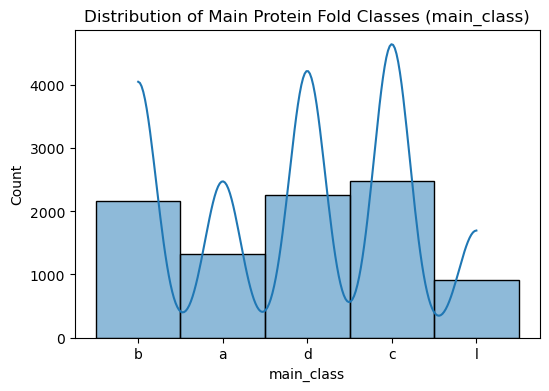

"\n# Crucial Check: Diversity of Slit Width (a) within each Wavelength Class\nplt.figure(figsize=(10, 6))\nsns.boxplot(x='class', y='I_x', data=metadata_df)\nplt.title('Slit Width (a) Distribution Across intensity ratio Classes')\nplt.ylabel('Slit Width (a) [m]')\nplt.xlabel('Wavelength Class Index')\nplt.show()\n"

In [45]:
# Assuming you have loaded your metadata_df
import seaborn as sns
import matplotlib.pyplot as plt
# metadata_df = pd.read_csv(os.path.join(metadata_dir, "metadata.csv")) 

# Check the distribution of slit separation (d) across ALL samples
plt.figure(figsize=(6, 4))
sns.histplot(parsed_df_clean['main_class'], kde=True)
plt.title('Distribution of Main Protein Fold Classes (main_class)')
plt.show()
"""
# Check the distribution of intensity (I_x) across ALL samples
plt.figure(figsize=(6, 4))
sns.histplot(metadata_df['d_lambda_ratio'], kde=True)
plt.title('Distribution of d_lambda_ratio Separation (d_lambda_ratio)')
plt.show()

"""
"""
# Crucial Check: Diversity of Slit Width (a) within each Wavelength Class
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='I_x', data=metadata_df)
plt.title('Slit Width (a) Distribution Across intensity ratio Classes')
plt.ylabel('Slit Width (a) [m]')
plt.xlabel('Wavelength Class Index')
plt.show()
"""

In [79]:

import torch.nn as nn
import torch.nn.functional as F

class Protein2DCNN(nn.Module):
    def __init__(self, num_classes, input_size=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.7)

        final_dim = input_size // (2*2*2)
        
        self.fc1 = nn.Linear(64* final_dim * final_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
       # x = self.pool(F.relu(self.conv4(x)))
        #print("Feature map shape before flatten:", x.shape)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = parsed_df['fold_label'].nunique()
#model = Protein3DCNN(num_classes)


In [80]:
def cnn_eval(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            
            # Loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall    = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1        = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1

In [81]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

weights = 1.0 / counts
weights = weights * (np.sum(counts) / len(counts))

class_weights = torch.tensor(weights, dtype=torch.float32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class_weights = class_weights.to(device)
model = Protein2DCNN(num_classes).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum = 0.9, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


cnn_train_loss_history = []
cnn_train_acc_history = []
cnn_val_loss_history = []
cnn_val_acc_history = []
cnn_val_f1_history = [] 
cnn_epoch_time = []
loss_bench = 0
n_epochs = 50


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Training metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    # Validation step
    val_loss, val_acc, val_prec, val_rec, val_f1 = cnn_eval(
        model, criterion, val_loader, device
    )
    
    scheduler.step(val_loss)

    # Store metrics
    cnn_train_loss_history.append(train_loss)
    cnn_train_acc_history.append(train_acc * 100)
    cnn_val_loss_history.append(val_loss)
    cnn_val_acc_history.append(val_acc * 100)
    cnn_val_f1_history.append(val_f1)
    cnn_epoch_time.append(end_time - start_time)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f} | "
          f"Time: {end_time - start_time:.2f}s")


Epoch 01: Train Loss: 1.3859, Train Acc: 0.2540 | Val Loss: 1.3836, Val Acc: 0.3827 | Precision: 0.3311, Recall: 0.3322, F1: 0.2484 | Time: 11.87s
Epoch 02: Train Loss: 1.3836, Train Acc: 0.2981 | Val Loss: 1.3810, Val Acc: 0.3619 | Precision: 0.2974, Recall: 0.3065, F1: 0.2243 | Time: 11.86s
Epoch 03: Train Loss: 1.3795, Train Acc: 0.3346 | Val Loss: 1.3743, Val Acc: 0.3771 | Precision: 0.3016, Recall: 0.3309, F1: 0.2510 | Time: 11.85s
Epoch 04: Train Loss: 1.3726, Train Acc: 0.3300 | Val Loss: 1.3641, Val Acc: 0.4156 | Precision: 0.2993, Recall: 0.3809, F1: 0.2973 | Time: 11.84s
Epoch 05: Train Loss: 1.3601, Train Acc: 0.3343 | Val Loss: 1.3455, Val Acc: 0.4268 | Precision: 0.3455, Recall: 0.3808, F1: 0.3100 | Time: 11.85s
Epoch 06: Train Loss: 1.3419, Train Acc: 0.3611 | Val Loss: 1.3142, Val Acc: 0.3771 | Precision: 0.3741, Recall: 0.3459, F1: 0.2686 | Time: 11.82s
Epoch 07: Train Loss: 1.3017, Train Acc: 0.4182 | Val Loss: 1.2496, Val Acc: 0.4952 | Precision: 0.5486, Recall: 0.530

In [82]:
test_loss, test_acc, test_prec, test_rec, test_f1 = cnn_eval(
    model, criterion, test_loader, device
)

print("\n--- FINAL TEST RESULTS ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")

print(f"Recall: {test_rec:.4f}")
print(f"F1 Score: {test_f1:.4f}")


--- FINAL TEST RESULTS ---
Test Loss: 0.5565
Test Acc: 0.8187
Precision: 0.8189
Recall: 0.8227
F1 Score: 0.8204


In [83]:
from sklearn.metrics import confusion_matrix

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model, val_loader, device)
cm = confusion_matrix(labels, preds)
print(cm)



[[281  10  14  12]
 [  7 447  26  39]
 [ 25  32 494  45]
 [ 28  32  62 419]]


In [27]:
from sklearn.metrics import confusion_matrix

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model, test_loader, device)
cm = confusion_matrix(labels, preds)
print(cm)

[[225   3  13   5   5]
 [  9 345  15  44  40]
 [ 33  11 357  66  18]
 [ 27  21  69 319  12]
 [ 35  42  50  46  29]]


<Figure size 640x480 with 0 Axes>

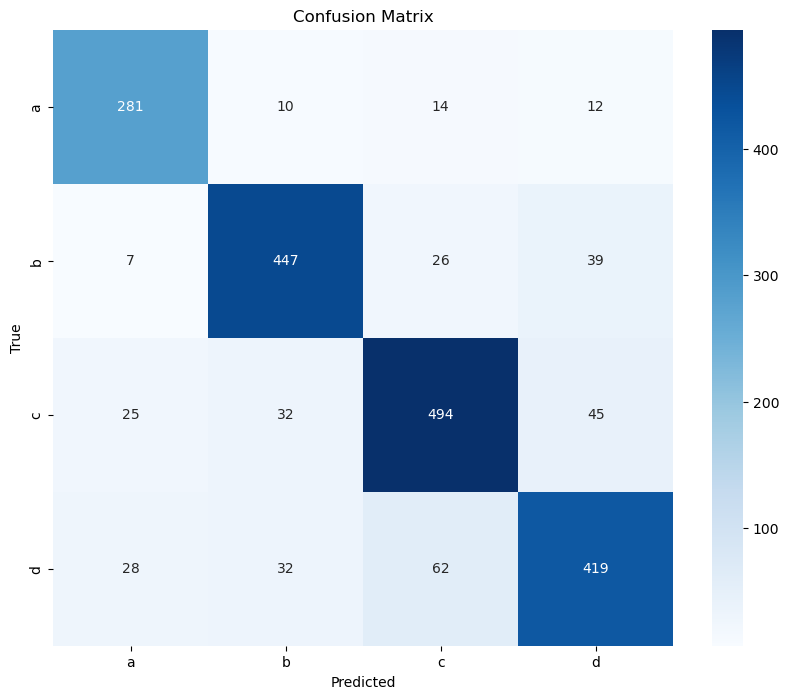

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["a", "b", "c", "d"]   
plt.savefig('protein_fold_4FoldLabels_ConfusionMatrix.png')
plot_confusion_matrix(cm, class_names)

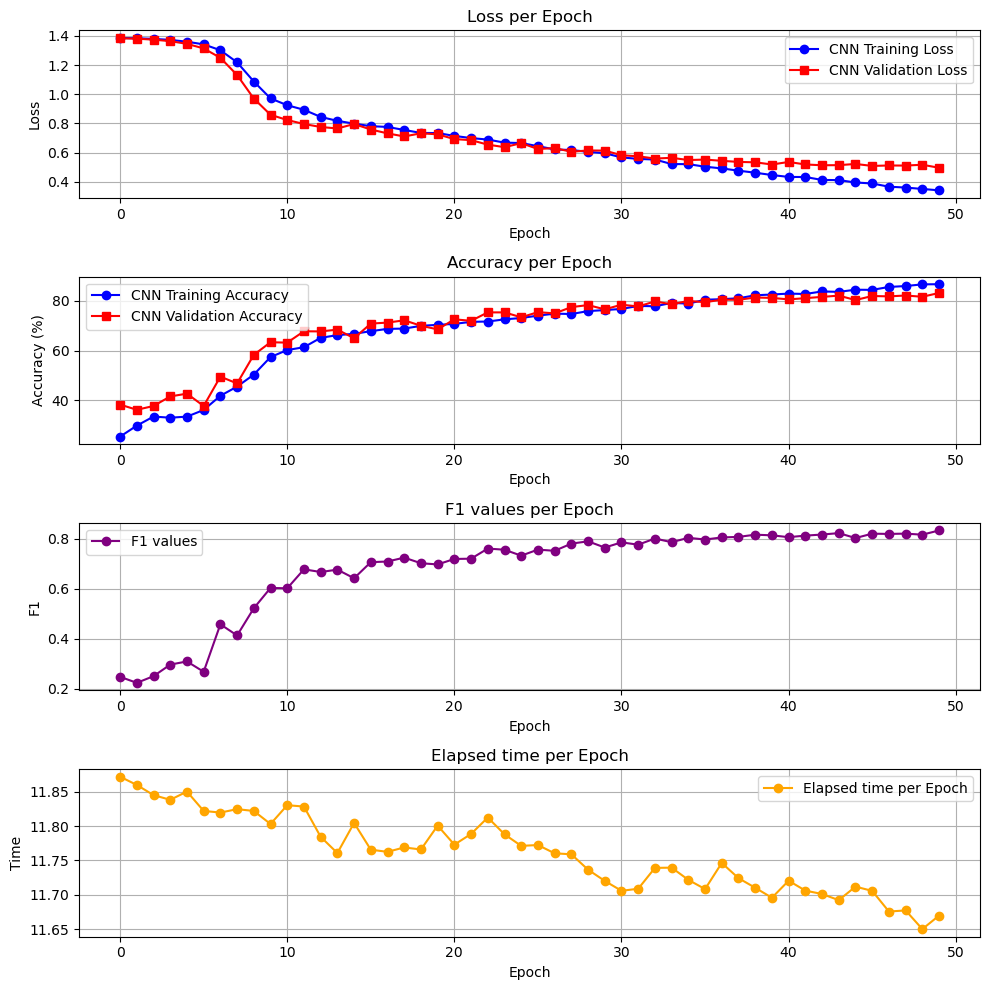

In [85]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(4, 1,1)
plt.plot(cnn_train_loss_history, marker='o', label='CNN Training Loss', color='blue')
plt.plot(cnn_val_loss_history,marker='s', label='CNN Validation Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(4, 1, 2)
plt.plot(cnn_train_acc_history, marker= 'o', label='CNN Training Accuracy', color= 'blue')
plt.plot(cnn_val_acc_history,marker= 's', label= 'CNN Validation Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(cnn_val_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(cnn_epoch_time, marker= 'o', label='Elapsed time per Epoch', color= 'orange')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Elapsed time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('protein_fold_classification_2DCNN_4FoldLabels_.png')
plt.show()

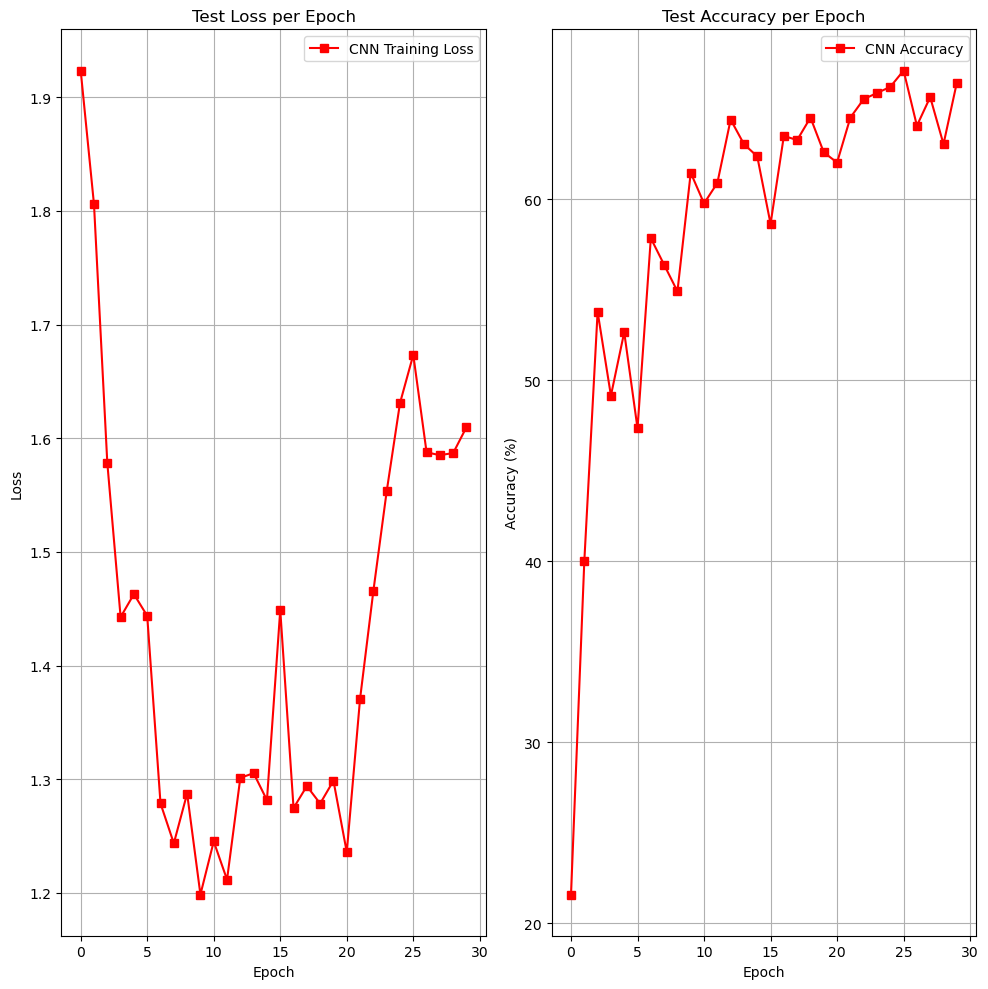

In [39]:
"""
import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
#plt.plot(train_losses, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(test_loss_history,marker='s', label='CNN Training Loss', color='red')
plt.title('Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
#plt.plot(test_accuracies, marker= 'o', label='QCNN Accuracy', color= 'blue')
plt.plot(test_acc_history,marker= 's', label= 'CNN Accuracy', color= 'red')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()




plt.tight_layout()
#plt.savefig('mnist_cnn.png')
plt.show()
"""

In [40]:
# Save the current model state dictionary
torch.save(model.state_dict(), 'final_2d_cnn_best_epoch_30.pth')

In [41]:
model.load_state_dict(torch.load('final_2d_cnn_best_epoch_30.pth', map_location=device))
model.eval() # Set the model to evaluation mode

Protein2DCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)

In [27]:
df_filtered.columns

Index(['domain', 'pdb_id', 'chain', 'fold_id', 'main_class', 'mapped_class'], dtype='object')

In [70]:
# Select a random sample from the filtered DataFrame
#random_sample = parsed_df.sample(n=1).iloc[0]
protein_id = "4FH8"
random_sample = parsed_df[parsed_df["pdb_id"] == protein_id]

random_sample = random_sample.iloc[0]
#print(random_sample)
# 1. Extract the data and true label
# Assuming 'coords' is the column containing the array of C-alpha coordinates
# and 'mapped_class' is the re-indexed label (0-7)
protein_coords = random_sample['ca_coords']
true_label_index = random_sample['main_class']
protein_id = random_sample['pdb_id'] # Use a relevant ID column for tracking

# 2. Generate the Distance Map (assuming you have this function available)
# The output should be 128x128 or whatever size your model expects
distance_map = calculate_distance_matrix(protein_coords)

# 3. Add Channel and Batch Dimensions for PyTorch (1, 1, 128, 128)
# Ensure the data type is float32
input_tensor = torch.tensor(distance_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

#print(f"--- Testing Protein: {protein_id} ---")
#print(f"True Class Index (Mapped): {true_label_index}")
#print(f"Tensor shape: {input_tensor.shape}")

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    
predicted_class = predicted.item()

#print("Predicted Class Index:", predicted_class)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x28224 and 16384x128)

In [62]:
specific_protein_row = parsed_df[parsed_df['pdb_id'] == '5NI7']
print(specific_protein_row)

     pdb_id chain  fold_id   domain main_class  n_residues  \
8534   5NI7     A  l.1.1.1  d5ni7a2          l         252   

                                                res_ids  \
8534  [258, 259, 260, 261, 262, 263, 264, 265, 266, ...   

                                              ca_coords  fold_label  
8534  [[3.701, -10.196, -25.979], [0.272, -11.524, -...           4  


In [86]:
import pennylane as qml
import os
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.func import vmap

In [19]:
#AutoEncoder Class

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=8):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(1*128*128, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(f"Input:{x.shape}")
        x = torch.flatten(x, start_dim=1)
        #print(f"After conv1: {x.shape}")
        x = F.relu(self.linear1(x))
        #print(f"After conv2: {x.shape}")
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        #print(f"Output (Latent): {x.shape}")
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4, 512)
        self.fc2 = nn.Linear(512, 64 * 16 * 16)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        #print(f"Input (Latent): {x.shape}")
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #print(f"After fc2: {x.shape}")
        x = x.view(-1, 64, 16, 16)
        #print(f"After view: {x.shape}")
        x = torch.relu(self.deconv1(x))
        #print(f"After deconv1: {x.shape}")
        x = torch.relu(self.deconv2(x))
        #print(f"After deconv2: {x.shape}")
        x = torch.sigmoid(self.deconv3(x))
        #print(f"Output (Reconstruction): {x.shape}")
        return x


In [113]:
dev = qml.device("default.qubit", wires=10)

In [114]:
# QCNN layer
def qcnn_block(weights,wires):
    
    for w in range(wires):
        qml.Hadamard(w)
    
    #qml.Toffoli(wires=(0,1,2))
    # Convolution Layer 1
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[0], wires=1)
    qml.CNOT(wires=[2, 3])
    qml.RZ(weights[1], wires=3)
    qml.CNOT(wires=[4, 5])
    qml.RY(weights[3], wires=5)
    qml.CNOT(wires=[6, 7])
    qml.RY(weights[5], wires=7)
    qml.CNOT(wires=[8, 9])
    qml.RY(weights[7], wires=9)
    
    # Pooling Layer 1
    qml.CNOT(wires=[1, 0])
    qml.RY(weights[2], wires=0)  # keep 0, discard 1
    qml.CNOT(wires=[3, 2])
    qml.RY(weights[4], wires=2)  # keep 2, discard 3
    qml.CNOT(wires=[5, 4])
    qml.RY(weights[6], wires=4)  # keep 4, discard 5
    qml.CNOT(wires=[7, 6])
    qml.RY(weights[8], wires=6)  # keep 6, discard 7
    qml.CNOT(wires=[9, 8])
    qml.RY(weights[10], wires=8)  # keep 8, discard 9
    
    # Convolution Layer 2
    qml.CNOT(wires=[0, 2])
    qml.RZ(weights[9], wires=2)
    qml.CNOT(wires=[4, 6])
    qml.RY(weights[11], wires=4)
    #qml.CNOT(wires=[4, 6])
    #qml.RY(weights[9], wires=6)
    #qml.CNOT(wires=[6, 8])
    #qml.RY(weights[6], wires=8)
"""
    # Pooling Layer 2
    qml.CNOT(wires=[4, 2])
    qml.RY(weights[10], wires=2)  # keep 0, discard 1
    #qml.CNOT(wires=[5, 3])
    #qml.RY(weights[11], wires=3)  # keep 2, discard 3
    #qml.CNOT(wires=[5, 4])
    #qml.RY(weights[10], wires=4)  # keep 4, discard 5
    #qml.CNOT(wires=[7, 6])
    #qml.RY(weights[8], wires=6)  # keep 6, discard 7
    #qml.CNOT(wires=[9, 8])
    #qml.RY(weights[10], wires=8)  # keep 8, discard 9
    """
""" 
# Convolution Layer 3 (Final Layer)
    qml.CNOT(wires=[2, 0])
    qml.RY(weights[11], wires=0)
    qml.CNOT(wires=[6, 4])
    qml.RY(weights[12], wires=4)
    """

' \n# Convolution Layer 3 (Final Layer)\n    qml.CNOT(wires=[2, 0])\n    qml.RY(weights[11], wires=0)\n    qml.CNOT(wires=[6, 4])\n    qml.RY(weights[12], wires=4)\n    '

In [115]:
# Full QCNN circuit

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle encoding
    qml.templates.AngleEmbedding(inputs, wires=range(10), rotation='Y')
    qcnn_block(weights,wires=10)
    #print(qml.draw(qcnn_block)(weights))
    return [qml.expval(qml.PauliZ(i)) for i in [0,2,4,6]]

In [65]:
quantum_circuit()
tape = construct_tape(quantum_circuit)()
ops = tape.operations
obs = tape.observables
g = CircuitGraph(ops, obs, tape.wires)

TypeError: quantum_circuit() missing 2 required positional arguments: 'inputs' and 'weights'

In [24]:
weight_shapes = {"weights": (12,)}
qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)

#QCNN and AutoEncoder Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dims=4)
        self.quantum = qcnn_layer
        self.decoder = Decoder()
        self.fc_out = nn.Linear(8, 4)  # Output logits for 5 fold classes

    
    def forward(self, x):
        latent = self.encoder(x)                      # Compress image to latent space
        #print(f"--- Hybrid Pass ---")
        #print(f"Latent Output to Quantum: {latent.shape}")
        quantum_out = self.quantum(latent)            # Quantum processing
        #print(f"Quantum Output to Decoder: {quantum_out.shape}")
        recons_image = self.decoder(quantum_out)      # reconstruction of image
        class_logits = self.fc_out(quantum_out)   # Final classification layer
        #print(f"Classifier Logits: {class_logits.shape}")                
        return recons_image, F.log_softmax(class_logits, dim=1)

In [116]:

weight_shapes = {"weights": (12,)}
#qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)
        #outputs = [self.qlayer(sample) for sample in x]
        #return torch.stack(outputs)
        """
        outputs = []
        for i, sample in enumerate(x):
            out = self.qlayer(sample)
            outputs.append(out)
        stacked = torch.stack(outputs)
        #print("  Inside QuantumLayer: input", x.shape, "output", stacked.shape)
        return stacked
        """
#QCNN Model Class
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1*128*128,10) 
        self.qcnn = QuantumLayer()
        #self.qcnn = qcnn_layer
        self.fc2 = nn.Linear(in_features=4, out_features=16)
        self.fc3 = nn.Linear(16, 4)       # Output layer for 4 classes
    
    @staticmethod
    def check_for_nans(x):
        if torch.isnan(x).any():
            print("NaNs detected!")
        if torch.isinf(x).any():
            print("Infs detected!")
    
    def forward(self, x):
        x = x.view(x.size(0), -1 )
        #print("Input shape before fc1:", x.shape)
        x = torch.tanh(self.fc1(x))
        #print("Shape after fc1:", x.shape)
        self.check_for_nans(x)
        x = self.qcnn(x) # [batch_size, 2]
        x = F.relu(self.fc2(x))
        #print("Shape after fc2:", x.shape)
        self.check_for_nans(x)
        x = self.fc3(x)
        #print("Shape after fc3:", x.shape)
        self.check_for_nans(x)
        #return F.log_softmax(x, dim=1)
        return x

In [117]:
for features, labels in train_loader:
    print("Label sample:", labels)
    print("Label min:", labels.min().item(), "max:", labels.max().item())
    break

Label sample: tensor([1, 3, 1, 3, 3, 2, 0, 3, 3, 0, 3, 1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 2,
        0, 3, 0, 1, 0, 1, 1, 2])
Label min: 0 max: 3


In [118]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = QCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


# History lists for plotting
qcnn_train_loss_history = []
qcnn_train_acc_history = []
qcnn_val_loss_history = []
qcnn_val_acc_history = []
qcnn_val_f1_history = [] 
qcnn_epoch_time = []

loss_bench = 0
n_epochs = 50

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


#Validation Function
def qcnn_eval(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            
            # Loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall    = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1        = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1

"""
def qcnn_val(model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            reconstructed_image, classification_logits = model(features)
            # Use only the classification_logits for the loss calculation
            loss = criterion(classification_logits, labels)
            #outputs = model(features)
            
            # Calculate and accumulate loss
            #loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(classification_logits.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(test_loader)
        accuracy = correct / len(test_loader.dataset)
        
    # Calculate macro-averaged metrics
    # Note: Scikit-learn requires non-empty lists, which is guaranteed here
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1
"""
# --- Training Loop ---

loss_bench = 0
n_epochs = 50


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        #labels = labels.long()

        # Double check after conversion
        
        #print("Labels dtype:", labels.dtype)  # Should print torch.int64
        #print("Labels range:", labels.min(), labels.max())  # Should be between [0, 3] for a 4-class problem
        #assert labels.min() >= 0 and labels.max() < 4, "Labels are out of range!"  # Check for out-of-range labels
        optimizer.zero_grad()
        outputs = model(features)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Training metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    # Validation step
    val_loss, val_acc, val_prec, val_rec, val_f1 = cnn_eval(
        model, criterion, val_loader, device
    )
    
    scheduler.step(val_loss)

    # Store metrics
    qcnn_train_loss_history.append(train_loss)
    qcnn_train_acc_history.append(train_acc * 100)
    qcnn_val_loss_history.append(val_loss)
    qcnn_val_acc_history.append(val_acc * 100)
    qcnn_val_f1_history.append(val_f1)
    qcnn_epoch_time.append(end_time - start_time)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f} | "
          f"Time: {end_time - start_time:.2f}s")

print(f"Parameter Count: {count_parameters(model)}|")
"""
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader:
        
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        reconstructed_image, classification_logits = model(features)
        # Use only the classification_logits for the loss calculation
        loss = criterion(classification_logits, labels)
        #outputs = model(features)
        #loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(classification_logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = correct /len(train_loader.dataset)
    
    # Store Training History
    train_loss_history.append(train_avg_loss)
    train_acc_history.append(train_accuracy*100)
    
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = qcnn_eval(model, criterion, device,)

    scheduler.step(val_loss)
    
    # Store Test History
    test_loss_history.append(val_loss)
    test_acc_history.append(val_accuracy*100)
    test_f1_history.append(val_f1) # Example of tracking
    
    
    epoch_duration = end_time - start_time
    
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")
print(f"Parameter Count: {count_parameters(model)}|")
"""

Epoch 01: Train Loss: 1.3880, Train Acc: 0.2861 | Val Loss: 1.3794, Val Acc: 0.3183 | Precision: 0.2229, Recall: 0.2918, F1: 0.2354 | Time: 14.24s
Epoch 02: Train Loss: 1.3666, Train Acc: 0.3465 | Val Loss: 1.3594, Val Acc: 0.3588 | Precision: 0.1863, Recall: 0.3046, F1: 0.2036 | Time: 14.41s
Epoch 03: Train Loss: 1.3566, Train Acc: 0.3574 | Val Loss: 1.3501, Val Acc: 0.3730 | Precision: 0.1974, Recall: 0.3186, F1: 0.2206 | Time: 14.29s
Epoch 04: Train Loss: 1.3509, Train Acc: 0.3567 | Val Loss: 1.3469, Val Acc: 0.3588 | Precision: 0.1861, Recall: 0.3046, F1: 0.2035 | Time: 15.28s
Epoch 05: Train Loss: 1.3457, Train Acc: 0.3626 | Val Loss: 1.3325, Val Acc: 0.4055 | Precision: 0.2040, Recall: 0.3537, F1: 0.2556 | Time: 14.54s
Epoch 06: Train Loss: 1.3387, Train Acc: 0.3767 | Val Loss: 1.3313, Val Acc: 0.3887 | Precision: 0.2539, Recall: 0.3332, F1: 0.2362 | Time: 14.31s
Epoch 07: Train Loss: 1.3371, Train Acc: 0.3695 | Val Loss: 1.3399, Val Acc: 0.3568 | Precision: 0.1893, Recall: 0.302

'\nfor epoch in range(n_epochs):\n    model.train()\n    running_loss = 0.0\n    total = 0\n    correct = 0\n    start_time = time.time()\n    \n    for features, labels in train_loader:\n        \n        features, labels = features.to(device), labels.to(device)\n        optimizer.zero_grad()\n        reconstructed_image, classification_logits = model(features)\n        # Use only the classification_logits for the loss calculation\n        loss = criterion(classification_logits, labels)\n        #outputs = model(features)\n        #loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        \n        running_loss += loss.item()\n\n        _, predicted = torch.max(classification_logits.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n    end_time = time.time()\n    \n    # Calculate Training Metrics\n    train_avg_loss = running_loss / len(train_loader)\n    train_accuracy = correct /len(train_loader.d

In [60]:
from ptflops import get_model_complexity_info
inputs, _ = next(iter(train_loader))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

Input shape before fc1: torch.Size([1, 16384])
QCNN(
  131.25 k, 99.986% Params, 131.25 KMac, 99.988% MACs, 
  (fc1): Linear(131.08 k, 99.861% Params, 131.08 KMac, 99.862% MACs, in_features=16384, out_features=8, bias=True)
  (qcnn): QuantumLayer(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc2): Linear(80, 0.061% Params, 80.0 Mac, 0.061% MACs, in_features=4, out_features=16, bias=True)
  (fc3): Linear(85, 0.065% Params, 85.0 Mac, 0.065% MACs, in_features=16, out_features=5, bias=True)
)


In [59]:
sample_inputs = np.random.rand(8)       # length 8 for AngleEmbedding
sample_weights = np.random.rand(12)     # length 12 for your QCNN block

specs = qml.specs(quantum_circuit)(sample_inputs, sample_weights)
resources = specs["resources"]

print("Device wires:", specs["num_device_wires"])
print("Tape wires:", specs["num_tape_wires"])
print("Circuit depth:", resources.depth)

gate_count = resources.num_gates
print("Gate count:", gate_count)

gate_breakdown = resources.gate_types
print("Gate breakdown:", gate_breakdown)

print("Number of observables:", specs["num_observables"])

Device wires: 8
Tape wires: 8
Circuit depth: 10
Gate count: 35
Gate breakdown: defaultdict(<class 'int'>, {'AngleEmbedding': 1, 'Hadamard': 8, 'CNOT': 13, 'RZ': 3, 'RY': 10})
Number of observables: 4


In [36]:
import fvcore
from fvcore.nn import FlopCountAnalysis
from fvcore.nn import flop_count_str

single_batch = next(iter(train_loader))

if isinstance(single_batch, (list, tuple)):
    input_tensor = single_batch[0]
else:
    input_tensor = single_batch

input_tensor = input_tensor.to(device)


all_features = []
for features_batch in train_loader:
    if isinstance(features_batch, (list, tuple)):
        features_batch = features_batch[0]
    all_features.append(features_batch)
    
features_tensor = torch.cat(all_features, dim=0)
#labels_tensor = torch.cat(all_labels, dim=0)

features_tensor = features_tensor.to(device)

input_tensor = features_tensor[0:1]
input_tensor = input_tensor.to(device)

print(f"✅ Input Tensor Shape used for FLOPs: {input_tensor.shape}")
flops = FlopCountAnalysis(model, (input_tensor,))
"""
print("\n✅ FLOPs Analysis by Module:")
print(flops.total())
print(flops.by_module())
"""
#print(fvcore.nn.update_bn_stats(model, train_loader, 50))
#print(fvcore.nn.parameter_count_table(model,3))
print(flop_count_str(flops))
#print(fvcore.nn.flop_count_table(fvcore.nn.flop_count.FlopCountAnalysis, 3, show_param_shapes: bool = True))
"""
from fvcore.nn import FlopCountAnalysis
flops = FlopCountAnalysis(model, input)
flops.total()
flops.by_operator()
flops.by_module()
flops.by_module_and_operator()
"""

✅ Input Tensor Shape used for FLOPs: torch.Size([1, 1, 128, 128])


IndexError: list index out of range

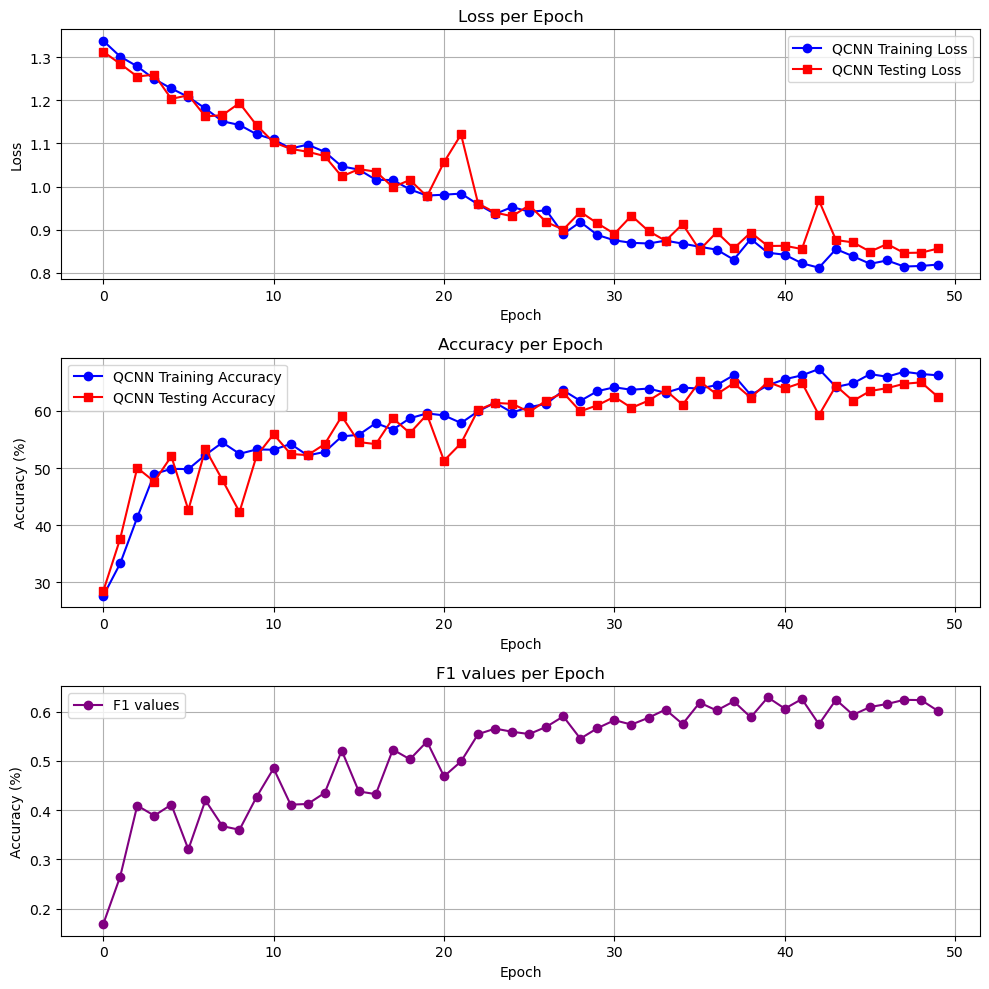

In [103]:
import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(3, 1,1)
plt.plot(qcnn_train_loss_history, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(qcnn_val_loss_history,marker='s', label='QCNN Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(3, 1, 2)
plt.plot(qcnn_train_acc_history, marker= 'o', label='QCNN Training Accuracy', color= 'blue')
plt.plot(qcnn_val_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(qcnn_val_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.tight_layout()
#plt.savefig('protein_qcnnVAE_2D_5000_8Qubits.png')
plt.show()

In [40]:
# Save the current model state dictionary
torch.save(model.state_dict(), 'final_2d_qcnn_best_epoch_50.pth')
model.load_state_dict(torch.load('final_2d_qcnn_best_epoch_50.pth', map_location=device))
model.eval()

QCNN(
  (qcnn): QuantumLayer(
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc2): Linear(in_features=4, out_features=5, bias=True)
  (fc1): Linear(in_features=16384, out_features=8, bias=True)
)

In [41]:
# Select a random sample from the filtered DataFrame
random_sample = parsed_df.sample(n=1).iloc[0]

# 1. Extract the data and true label
# Assuming 'coords' is the column containing the array of C-alpha coordinates
# and 'mapped_class' is the re-indexed label (0-7)
protein_coords = random_sample['ca_coords']
true_label_index = random_sample['main_class']
protein_id = random_sample['pdb_id'] # Use a relevant ID column for tracking

# 2. Generate the Distance Map (assuming you have this function available)
# The output should be 128x128 or whatever size your model expects
distance_map = calculate_distance_matrix(protein_coords)

# 3. Add Channel and Batch Dimensions for PyTorch (1, 1, 128, 128)
# Ensure the data type is float32
input_tensor = torch.tensor(distance_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

print(f"--- Testing Protein: {protein_id} ---")
print(f"True Class Index (Mapped): {true_label_index}")

--- Testing Protein: 5GY1 ---
True Class Index (Mapped): b


In [42]:
specific_protein_row = parsed_df[parsed_df['pdb_id'] == '5GY1']
print(specific_protein_row)

     pdb_id chain  fold_id   domain main_class  n_residues  \
3862   5GY1     B  b.2.2.0  d5gy1b2          b         601   

                                                res_ids  \
3862  [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...   

                                              ca_coords  fold_label  
3862  [[-12.586, -37.292, -11.518], [-11.304, -33.72...           1  
